In [127]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [128]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1016 non-null   object 
 1   SeasonNumber       1016 non-null   int64  
 2   SeasonVersion      1016 non-null   int64  
 3   Player             1016 non-null   object 
 4   MatchId            1016 non-null   object 
 5   Map                1016 non-null   object 
 6   Category           1016 non-null   object 
 7   Playlist           1016 non-null   object 
 8   Input              1016 non-null   object 
 9   Queue              1016 non-null   object 
 10  PreCsr             1016 non-null   int64  
 11  PostCsr            1016 non-null   int64  
 12  Rank               1016 non-null   int64  
 13  WasAtStart         1016 non-null   int64  
 14  WasAtEnd           1016 non-null   int64  
 15  WasInProgressJoin  1016 non-null   int64  
 16  Mmr                2 non

In [129]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'].replace(0, 1) / df['DamageTaken'].replace(0, 1)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']

## Ratios
df['Assists/Life'] = df['Assists'] / df['Deaths']
df.loc[df['Assists/Life'] == np.inf, 'Damage/KA'] = df['Assists']
df['Damage/KA'] = df['DamageDone'] / (df['Assists'] + df['Kills'])
df.loc[df['Damage/KA'] == np.inf, 'Damage/KA'] = df['DamageDone']

## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr', 'SeasonNumber', 'SeasonVersion'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               743 non-null    int64         
 1   Date                743 non-null    datetime64[ns]
 2   Map                 743 non-null    object        
 3   Category            743 non-null    object        
 4   Rank                743 non-null    int64         
 5   Outcome             743 non-null    int64         
 6   Accuracy            743 non-null    float64       
 7   DamageDone          743 non-null    int64         
 8   DamageTaken         743 non-null    int64         
 9   ShotsFired          743 non-null    int64         
 10  ShotsLanded         743 non-null    int64         
 11  ShotsMissed         743 non-null    int64         
 12  KD                  743 non-null    float64       
 13  KDA                 743 non-null    float64       

In [130]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,743.0,583.870794,255.004507,140.000000,361.500000,582.000000,807.500000,1.015000e+03
Rank,743.0,3.960969,2.149365,1.000000,2.000000,4.000000,5.000000,8.000000e+00
Outcome,743.0,0.555855,0.497205,0.000000,0.000000,1.000000,1.000000,1.000000e+00
Accuracy,743.0,52.475101,6.048286,0.000000,49.060000,52.630000,55.785000,8.056000e+01
DamageDone,743.0,5239.911171,1833.059094,0.000000,3903.000000,5027.000000,6483.000000,1.267300e+04
DamageTaken,743.0,4496.174966,1552.811359,0.000000,3469.500000,4337.000000,5539.500000,9.962000e+03
ShotsFired,743.0,234.078062,79.766248,0.000000,179.000000,226.000000,288.000000,5.170000e+02
ShotsLanded,743.0,122.655451,42.953460,0.000000,94.000000,118.000000,151.000000,2.860000e+02
ShotsMissed,743.0,111.422611,40.477662,0.000000,83.000000,109.000000,138.000000,2.610000e+02
KD,743.0,1.263190,0.746933,0.000000,0.830000,1.120000,1.450000,1.000000e+01


In [131]:
# dfr.tail()
print(round(dfr.sort_values('Dmg/10Min', ascending=False).iloc[:, :30],2).head(8))


     index                Date        Map          Category  Rank  Outcome  \
727    999 2024-04-07 18:05:50   Recharge           Oddball     3        1   
12     154 2023-10-20 19:33:13   Recharge        Extraction     1        1   
263    455 2023-11-27 22:55:34  Forbidden    CTF 3 Captures     3        1   
729   1001 2024-04-07 18:28:23   Empyrean    CTF 3 Captures     4        1   
310    513 2023-12-01 04:37:03   Solitude       Strongholds     5        0   
420    644 2024-01-18 02:37:59    Streets            Slayer     4        1   
305    502 2023-12-01 02:54:53   Solitude  King of the Hill     4        1   
670    935 2024-03-23 20:47:44   Recharge  King of the Hill     4        1   

     Accuracy  DamageDone  DamageTaken  ShotsFired  ...  Assists  Betrayals  \
727     61.45        6536         3003         262  ...       11          0   
12      58.10        4996         2339         210  ...        6          0   
263     60.94        3255         1110         128  ...     

In [132]:
# dfr.hist(bins=15, figsize=(18, 14))
# plt.tight_layout()
# plt.show()

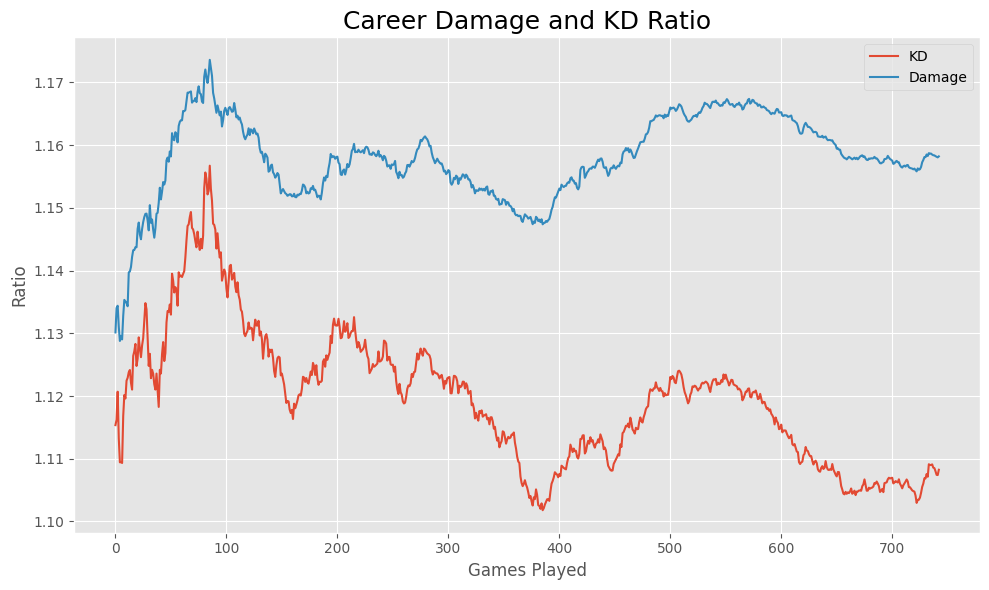

In [133]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Career Damage and KD Ratio', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/DamKD.png', dpi=300)
plt.show()

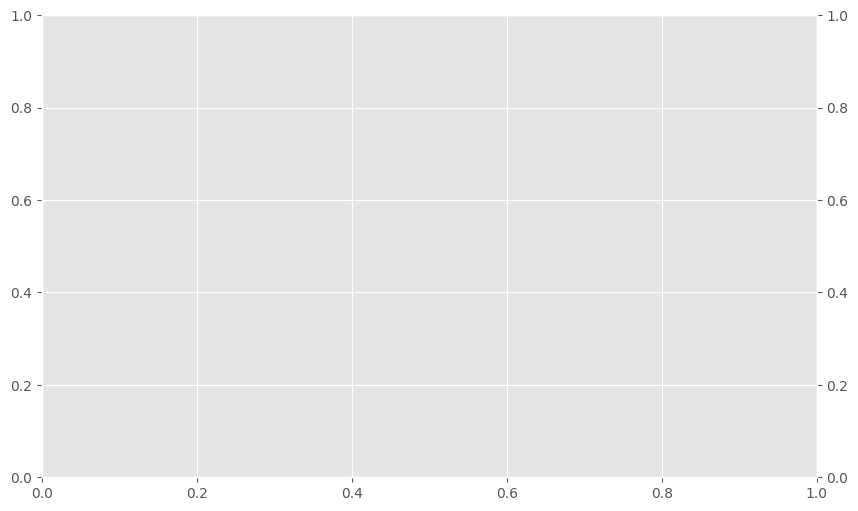

In [134]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams['animation.embed_limit'] = 300.0

dfr_date = dfr.index
dfr_kd = dfr['LifetimeKD']
dfr_dam = dfr['LifetimeDmgRatio']
dfr_csr = dfr['Csr']

# then assign df_date to x and df_close to y
x = dfr_date
y = dfr_kd
y2 = dfr_dam
y3 = dfr_csr

# calculate min and max x values + 1 and
# the min and max y values times scale factors
min_x = min(x)
max_x = max(x)
min_y = min(min(y), min(y2))
max_y = max(max(y), max(y2))
min_y3 = min(y3)
max_y3 = max(y3)

#########################################################################################
# generate and display animation line plot
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax2 = ax.twinx()

def animate(i):
    ax.cla() # clear the previous image
    ax2.cla()
    plt.title('KD/Damage Ratio and CSR over Time',fontsize=16)
    plt.xlabel('Game Played')
    plt.ylabel('Ratios/CSR')
    ax.plot(x[:i], y[:i], label='KD') # plot the line
    ax.plot(x[:i], y2[:i], label='Damage') # plot the line
    ax2.plot(x[:i], y3[:i], label='CSR', color='black')
    ax.set_xlim([0.99*min_x, 0.99*max_x]) # fix the x axis
    ax.set_ylim([0.99*min_y, 1.01*max_y]) # fix the y axis 
    ax2.set_xlim([0.99*min_x, 0.99*max_x])
    ax2.set_ylim(min_y3, 1.05*max_y3)
    ax.legend(loc='upper right')
#     ax2.legend(loc='lower right')
    
# anim = animation.FuncAnimation(fig, animate, frames = len(x), interval = 15)

# anim.save('Plots/KDDamCSR.gif', writer='imagemagick', fps=60)

# # Save the animation as HTML
# html_output = anim.to_html5_video()
# # Display the HTML animation in the Jupyter Notebook
# HTML(html_output)

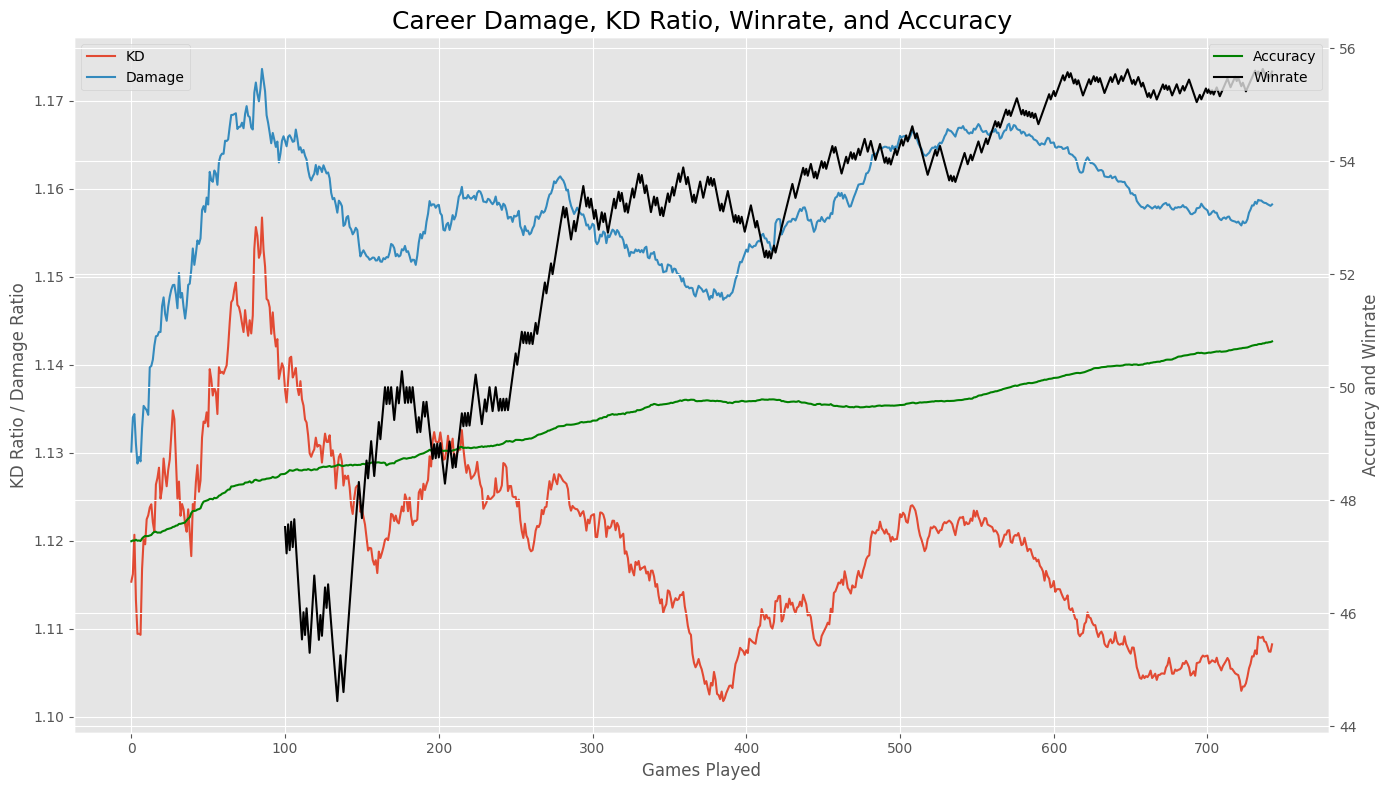

In [135]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax2.plot(dfr['LifetimeWinRate'][100:]*100, color='black', label='Winrate')
ax1.set_title('Career Damage, KD Ratio, Winrate, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy and Winrate')

ax1.yaxis.grid(True)
ax2.yaxis.grid(True)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDWRAcc.png', dpi=300)
plt.show()

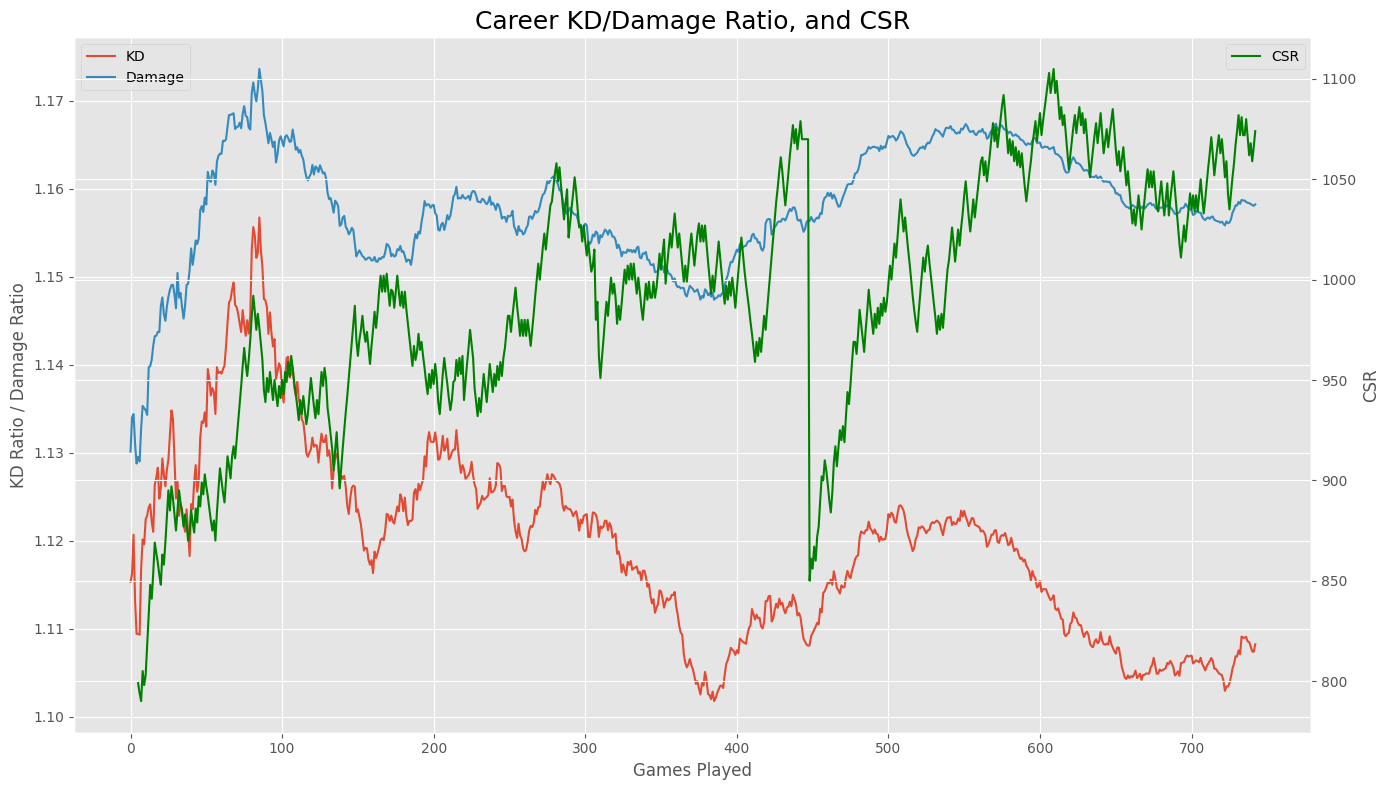

In [136]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'][5:], label='CSR', color='green')
ax1.set_title('Career KD/Damage Ratio, and CSR', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
# ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDCsr.png', dpi=300)
plt.show()

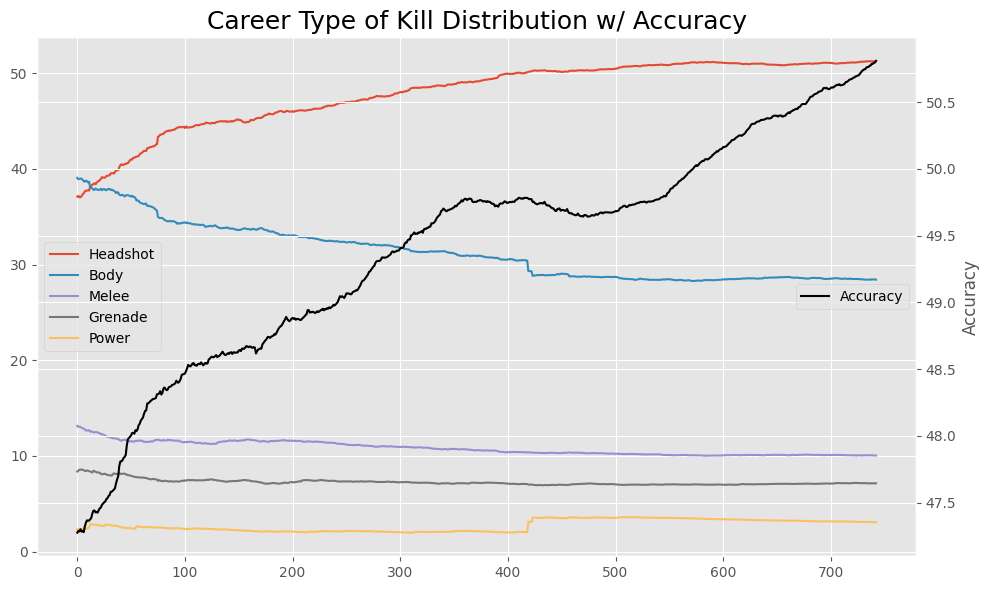

In [137]:
plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeHSPct'], label='Headshot')
ax1.plot(dfr['LifetimeBodyPct'], label='Body')
ax1.plot(dfr['LifetimeMeleePct'], label='Melee')
ax1.plot(dfr['LifetimeGrenadePct'], label='Grenade')
ax1.plot(dfr['LifetimePowerPct'], label='Power')
ax2.plot(dfr['LifetimeAcc'], label='Accuracy', color='black')
plt.title('Career Type of Kill Distribution w/ Accuracy', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Accuracy')
ax1.legend(loc='best')
ax2.legend(loc='right')
ax1.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/TypeKillAcc.png', dpi=300)
plt.show()

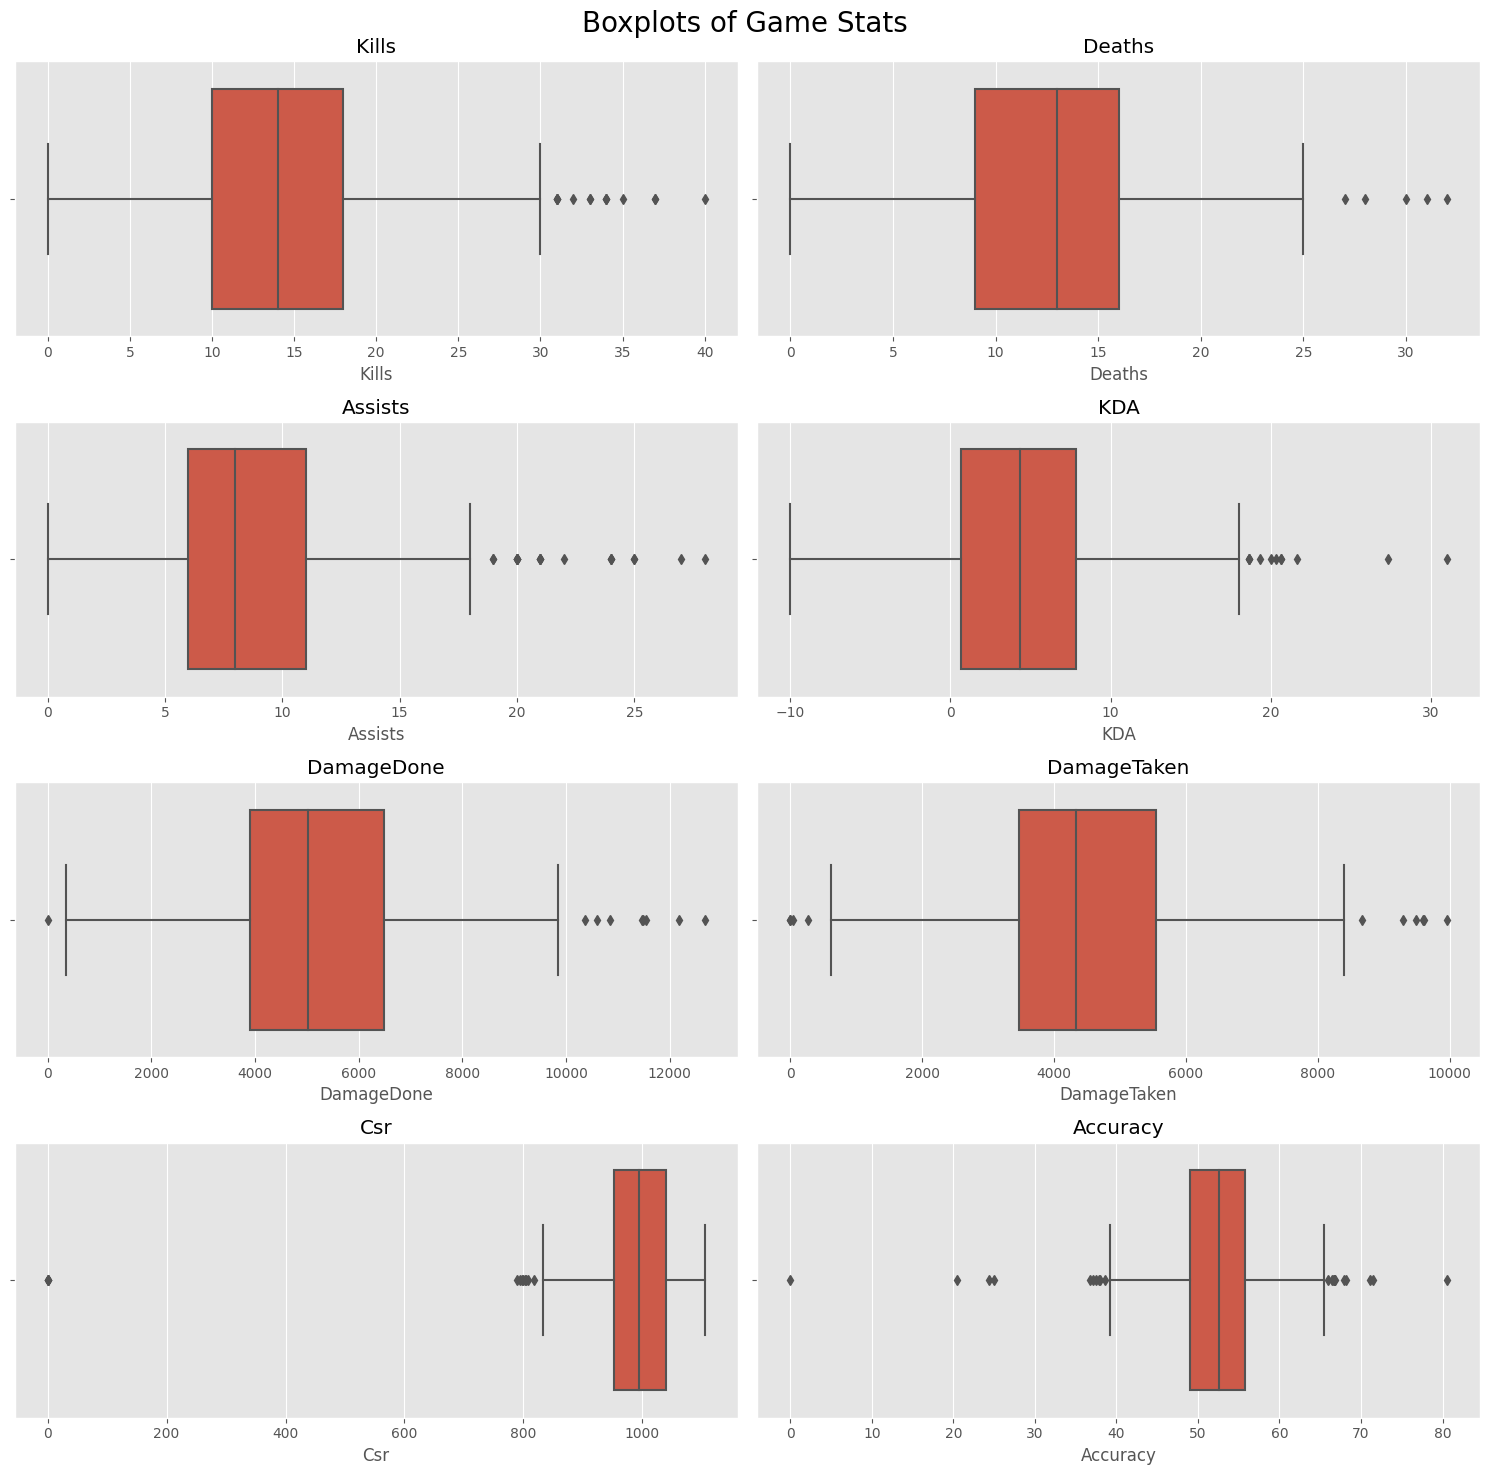

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=20)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


Last * Games stats  
Set mod to however many game you want to view 

In [139]:
# Last * Games

# mod = 10
# dfmod = dfr.tail(mod)

dfmod = dfr[dfr['DamageTaken'] < dfr['DamageDone']]
# dfmod = dfr[dfr['DamageTaken'] > dfr['DamageDone']]

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Winrate: {round((dfmod['Outcome']==1).sum() / (dfmod['Outcome']==0).sum() ,2)}")
print(f"Max CSR: {dfmod['Csr'].max()}")
# dfmod.sort_values('Kills', ascending=False).head(10)



Overall KD: 1.25
Accuracy: 53.03
Damage Ratio: 1.25
Win-Loss: 354-220
Winrate: 1.61
Max CSR: 1105


In [140]:
df['Assists/Life'].head(20)

0     0.333333
1     0.636364
2     0.111111
3     1.500000
4     0.666667
5     0.250000
6     0.500000
7     0.333333
8     1.000000
9     0.812500
10    0.200000
11    0.857143
12    0.454545
13    0.666667
14    0.636364
15    0.500000
16    1.333333
17    0.833333
18    0.333333
19    0.650000
Name: Assists/Life, dtype: float64

In [141]:
import plotly.express as px

mod = 25

fig = px.line(df, x=dfr.index, y=df['Accuracy'].rolling(window=mod).mean(), 
              labels={'x': 'Number of Games Played', 'y': 'Accuracy'},
              title='Rolling Avg Accuracy')

fig.show()


In [142]:
import plotly.express as px

mod = 25
name = 'Assists/Life'

fig = px.line(dfr, x=dfr.index, y=(dfr['Assists'].rolling(window=mod).mean() /
                                 dfr['Deaths'].rolling(window=mod).mean()), 
              labels={'x': 'Number of Games Played', 'y': f'{name}'},
              title=f'Rolling Avg {name}')

fig.show()


In [143]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfmod = dfr[dfr['DamageTaken'] < dfr['DamageDone']]
dfmod1 = dfr[dfr['DamageTaken'] > dfr['DamageDone']]

print('Overall')
print(f'Overall KD: {round(dfr["Kills/10Min"].sum() / dfr["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Dmg Done <> Taken: {len(dfmod)}-{len(dfmod1)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Totals')
print(f"Total Games: {dfr.Kills.count()}")
print(f"Total Kills: {dfr.Kills.sum()}")
print(f"Total Deaths: {dfr.Deaths.sum()}")
print(f"Total Assists: {dfr.Assists.sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills/10Min"].sum() / dfw["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills/10Min"].sum() / dfl["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.14
Average Kills: 13.59
Average Deaths: 11.96
Average Assists: 8.11
Average Accuracy: 52.4
Average Damage Done: 5240
Average Damage Taken: 4496
Damage Ratio: 1.17
Dmg Done <> Taken: 574-168
Win-Loss: 413-330
----------------------------
Totals
Total Games: 743
Total Kills: 10731
Total Deaths: 9544
Total Assists: 6377
----------------------------
Wins
Overall KD: 1.31
Average Kills: 14.11
Average Deaths: 10.74
Average Assists: 8.56
Average Accuracy: 52.78
Average Damage Done: 5073
Average Damage Taken: 4139
Damage Ratio: 1.23
Wins: 413
----------------------------
Losses
Overall KD: 0.96
Average Kills: 12.94
Average Deaths: 13.49
Average Assists: 7.54
Average Accuracy: 51.96
Average Damage Done: 5449
Average Damage Taken: 4943
Damage Ratio: 1.1
Losses: 330


In [144]:
# Ranks, 1 = Top Winner, 5 = Top Loser
g1 = dfr[dfr['Rank'] == 1].value_counts().count()
g5 = dfr[dfr['Rank'] == 5].value_counts().count()
g15 = round((g1 + g5) / len(dfr)*100,2)


print('Games Ranked 1:',g1)
print('Games Ranked 5:',g5)
print('MVP %:',g15 )

Games Ranked 1: 151
Games Ranked 5: 163
MVP %: 42.26


## Scorigami
Inspired by NFL, tracks unique statlines and counts if theyve occured before, only shows duplicate records instead of unique

In [145]:
# Create a new column for the combined score in the desired format
dfGami = pd.DataFrame()
dfGami['Kills'] = dfr['Kills']
dfGami['Deaths'] = dfr['Deaths']
dfGami['Assists'] = dfr['Assists']
dfGami['Scorigami'] = dfr['Kills'].astype(str) + '-' + dfr['Deaths'].astype(str) + '-' + dfr['Assists'].astype(str)

# Get unique scorigami scores
scorigami_list = dfGami['Scorigami'].unique()

dfGami = dfGami.sort_values(by=['Kills', 'Deaths', 'Assists'], ascending=False)
# print(dfGami.head())
dfGami.to_csv('Scorigami.csv')

In [146]:
gamiPiv = dfGami.pivot_table(index='Scorigami', aggfunc='size')

gamiPiv = gamiPiv.sort_index()

print("Records with >= 3 Scori:",gamiPiv[gamiPiv.values>2].count())
print(gamiPiv[gamiPiv.values>2].sort_values(ascending=False))


Records with >= 3 Scori: 7
Scorigami
13-11-9     3
15-8-7      3
17-15-9     3
19-18-10    3
6-11-8      3
7-12-7      3
8-11-5      3
dtype: int64


In [147]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
round(dfrc.sort_values('Length%', ascending=False),2)

,LengthMinutes,Count,Length%,Count%
Category,,,,
Slayer,1478.83,172,18.98,23.15
CTF 3 Captures,1384.95,126,17.77,16.96
Oddball,1319.28,110,16.93,14.80
Strongholds,1274.97,109,16.36,14.67
King of the Hill,1257.08,117,16.13,15.75
Extraction,611.85,70,7.85,9.42
CTF 5 Captures,465.38,39,5.97,5.25


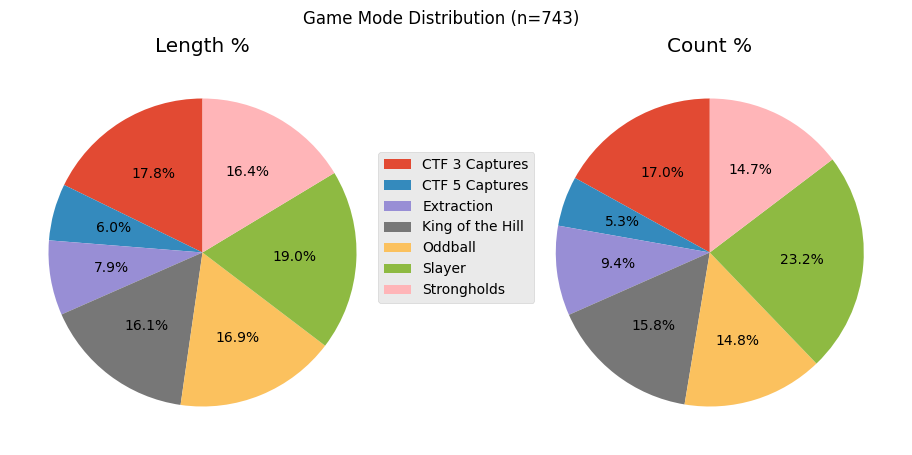

In [148]:
import matplotlib.pyplot as plt

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
fig.suptitle(f'Game Mode Distribution (n={totalcount})')
ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count %')
fig.legend(labels, loc="center")
plt.savefig('Plots/ModeDistro.png', dpi=300)
plt.show()

In [149]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Length%'], ascending=False)
dfrc

,,Count,LengthHours,Outcome,Count%,Length%
Category,Map,,,,,
King of the Hill,Recharge,52,9.71,0.50,7.00,7.47
Strongholds,Solitude,45,9.20,0.47,6.06,7.08
CTF 3 Captures,Argyle,46,8.86,0.48,6.19,6.82
Oddball,Streets,43,8.66,0.63,5.79,6.67
CTF 3 Captures,Empyrean,41,7.84,0.51,5.52,6.04
CTF 5 Captures,Aquarius,39,7.76,0.46,5.25,5.97
Slayer,Solitude,51,7.50,0.67,6.86,5.77
Oddball,Recharge,37,7.25,0.59,4.98,5.58
Slayer,Aquarius,48,6.73,0.56,6.46,5.18


In [150]:
dfrcc = dfr.groupby(['Category','Map']).agg(
    Count=('Category', 'count'),
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)

dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) * 100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['Dmg/KA'] = dfrcc['DamageDone'] / (dfrcc['Kills'] + dfrcc['Assists'])
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min']
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
dfrcc = round(dfrcc.sort_values(['Winrate', 'Category', 'Map'], ascending=False), 2)
dfrcc

Count  Wins  Losses  Kills  Deaths  Assists  \
Category         Map                                                      
King of the Hill Live Fire     34    26       8    508     466      299   
Slayer           Solitude      51    34      17    540     535      363   
                 Streets       29    19      10    266     265      192   
                 Recharge      17    11       6    162     159      115   
Oddball          Streets       43    27      16    752     670      459   
Extraction       Recharge      18    11       7    230     193      143   
                 Streets       33    20      13    453     351      253   
Oddball          Live Fire     30    18      12    496     482      318   
                 Recharge      37    22      15    597     503      382   
Slayer           Aquarius      48    27      21    505     489      320   
CTF 3 Captures   Forbidden     39    21      18    498     406      251   
Slayer           Live Fire     27    14      13    276     274      154   
King of the Hill Solitude      31    16      15    511     417      309   
CTF 3 Captures   Empyrean      41    21      20    632     581      329   
Strongholds      Live Fire     30    15      15    474     408      218   
King of the Hill Recharge      52    26      26    868     772      615   
CTF 3 Captures   Argyle        46    22      24    690     591      330   
Strongholds      Recharge      34    16      18    481     482      302   
                 Solitude      45    21      24    847     707      507   
CTF 5 Captures   Aquarius      39    18      21    715     577      393   
Extraction       Live Fire     19     8      11    230     216      125   

                            DamageDone  DamageTaken  Winrate  LengthMinutes  \
Category         Map                                                          
King of the Hill Live Fire      178393       159357     0.76         340.68   
Slayer           Solitude       211792       192107     0.67         449.70   
                 Streets        110028        97482     0.66         235.82   
                 Recharge        67949        63215     0.65         153.43   
Oddball          Streets        266942       224841     0.63         519.35   
Extraction       Recharge        80159        66596     0.61         165.43   
                 Streets        147191       118482     0.61         284.25   
Oddball          Live Fire      184302       157735     0.60         365.15   
                 Recharge       216669       180418     0.59         434.78   
Slayer           Aquarius       199098       178051     0.56         403.85   
CTF 3 Captures   Forbidden      186925       149836     0.54         383.13   
Slayer           Live Fire      103115        99184     0.52         236.03   
King of the Hill Solitude       174890       144815     0.52         333.53   
CTF 3 Captures   Empyrean       227266       203482     0.51         470.10   
Strongholds      Live Fire      166089       146862     0.50         337.17   
King of the Hill Recharge       318210       268129     0.50         582.87   
CTF 3 Captures   Argyle         248272       208386     0.48         531.72   
Strongholds      Recharge       184271       166021     0.47         386.08   
                 Solitude       286814       241637     0.47         551.72   
CTF 5 Captures   Aquarius       252516       201671     0.46         465.38   
Extraction       Live Fire       82363        72351     0.42         162.17   

                            Accuracy    KD  DamageRatio  Dmg/Life  Dmg/KA  \
Category         Map                                                        
King of the Hill Live Fire     55.27  1.09         1.12    382.82  221.06   
Slayer           Solitude      50.72  1.01         1.10    395.87  234.54   
                 Streets       50.67  1.00         1.13    415.20  240.24   
                 Recharge      46.72  1.02         1.07    427.35  245.30   
Oddball          Stree

In [151]:
dfrcc = dfr.groupby('Category').agg(
    Count=('Category', 'count'),
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Wins,Losses,Kills,Deaths,Assists,ShotsLanded,ShotsFired,DamageDone,DamageTaken,Winrate,LengthMinutes,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,,,,,,
Slayer,172,105,67,1749,1722,1144,16824,33304,691982,630039,0.61,1478.83,1.02,1.10,401.85,35.97,0.66
Oddball,110,67,43,1845,1655,1159,15122,28530,667913,562994,0.61,1319.28,1.11,1.19,403.57,63.40,0.70
King of the Hill,117,68,49,1887,1655,1223,15479,29228,671493,572301,0.58,1257.08,1.14,1.17,405.74,59.93,0.74
Extraction,70,39,31,913,760,521,7421,13807,309713,257429,0.56,611.85,1.20,1.20,407.52,68.79,0.69
CTF 3 Captures,126,64,62,1820,1578,910,15560,29722,662463,561704,0.51,1384.95,1.15,1.18,419.81,63.85,0.58
Strongholds,109,52,57,1802,1597,1027,14646,27892,637174,554520,0.48,1274.97,1.13,1.15,398.98,51.76,0.64
CTF 5 Captures,39,18,21,715,577,393,6081,11437,252516,201671,0.46,465.38,1.24,1.25,437.64,88.12,0.68


In [152]:
dfrcc = dfr.groupby('Map').agg(
    Count=('Category', 'count'),
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Wins,Losses,Kills,Deaths,Assists,ShotsLanded,ShotsFired,DamageDone,DamageTaken,Winrate,LengthMinutes,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,,,,,,
Streets,105,66,39,1471,1286,904,12485,23362,524161,440805,0.63,1039.42,1.14,1.19,407.59,64.82,0.70
Live Fire,140,81,59,1984,1846,1114,16124,29900,714262,635489,0.58,1441.20,1.07,1.12,386.92,42.67,0.60
Solitude,127,71,56,1898,1659,1179,15721,30015,673496,578559,0.56,1334.95,1.14,1.16,405.97,57.23,0.71
Recharge,158,86,72,2338,2109,1557,20230,39918,867258,744379,0.54,1722.60,1.11,1.17,411.22,58.26,0.74
Forbidden,39,21,18,498,406,251,4400,8318,186925,149836,0.54,383.13,1.23,1.25,460.41,91.35,0.62
Aquarius,87,45,42,1220,1066,713,11013,21003,451614,379722,0.52,869.23,1.14,1.19,423.65,67.44,0.67
Empyrean,41,21,20,632,581,329,5398,10329,227266,203482,0.51,470.10,1.09,1.12,391.16,40.94,0.57
Argyle,46,22,24,690,591,330,5762,11075,248272,208386,0.48,531.72,1.17,1.19,420.09,67.49,0.56


In [153]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 5.2976213750080206s
